In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from numba import jit
from sklearn.cluster import DBSCAN
from collections import Counter
from scipy.stats import cramervonmises
from scipy.stats import zscore
from scipy.stats import norm

In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['font.size'] = 15
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["text.usetex"] = False

In [3]:
micron_per_pixel = 1.0/23.5 # Value from Salman

## Import droplet radii for control cells 

In [4]:
dataset = pd.read_csv('Data/transcriptional_inhibition_data.csv')

dataset['centroid_r'] = dataset['centroid_r']*micron_per_pixel
dataset['centroid_c'] = dataset['centroid_c']*micron_per_pixel

dataset['radius'] = np.divide(dataset['pixels'], np.pi)**0.5
dataset['radius(microns)'] = dataset['radius']*micron_per_pixel
dataset['diameter(microns)'] = 2.0*dataset['radius(microns)']

dataset['sample_type'] = [val[0] for val in dataset['sample'].str.split('-')]

# Drop all elements of the dataset that are not control data
dataset = dataset.drop(dataset[dataset['sample_type'] != 'Control'].index)
dataset.head()

,sample,spot_id,pixels,mean_intensity,centroid_r,centroid_c,microns,radius,radius(microns),diameter(microns),sample_type
0,Control-roi-01,1,21,0.071200,0.042553,41.234043,0.037979,2.585441,0.110019,0.220038,Control
1,Control-roi-01,2,23,0.052959,0.042553,44.893617,0.041597,2.705758,0.115139,0.230277,Control
2,Control-roi-01,3,23,0.044684,0.127660,43.361702,0.041597,2.705758,0.115139,0.230277,Control
3,Control-roi-01,4,20,0.038597,0.212766,41.617021,0.036171,2.523133,0.107367,0.214735,Control
4,Control-roi-01,5,9,0.031769,0.170213,44.212766,0.016277,1.692569,0.072024,0.144048,Control


## Visualize clustering performance using DBSCAN

In [5]:
def cluster_points(points, epsilon=2.0, min_samples=3):
    """ Function to apply DBSCAN:
    
    Inputs:
    -------
    points (numpy.2darray): A list of (x,y) coordinates of the different points
    epsilon (float): Distance (in microns) within which points are considered neighbors
    min_samples (int): Minimum number of points in each cluster
    
    Outputs:
    clusters (numpy.1darray): Same size as points. Each point is assigned a cluster number.
    """
    
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    clusters = dbscan.fit_predict(points)
    return clusters

In [6]:
key_list = dataset['sample'].unique()
print(key_list)

points_size_dict = {'points': {}, 'size': {}, 'clusters': {}}

for key in key_list:

    points_size_dict['points'][key] = np.array([dataset['centroid_r'][dataset['sample']==key],
                                                dataset['centroid_c'][dataset['sample']==key]], 
                                               dtype=float).transpose()
    
    points_size_dict['size'][key] = np.array(dataset['diameter(microns)'][dataset['sample']==key])
    points_size_dict['clusters'][key] = cluster_points(points_size_dict['points'][key])

['Control-roi-01' 'Control-roi-03' 'Control-roi-05' 'Control-roi-07']


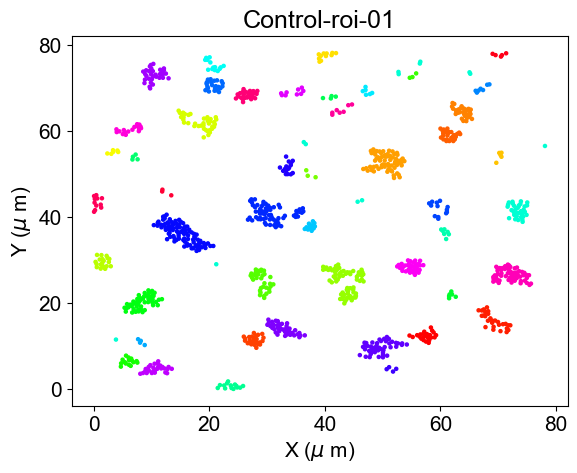

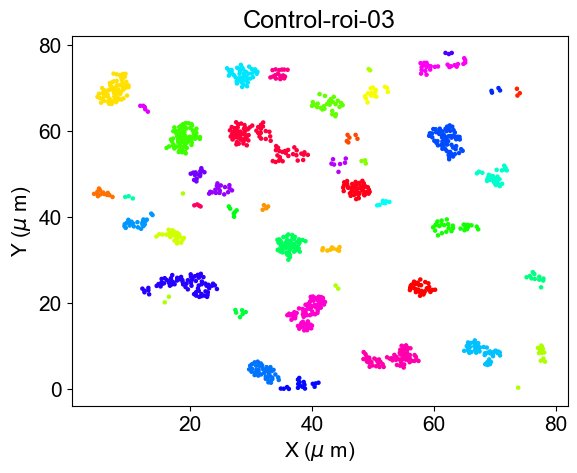

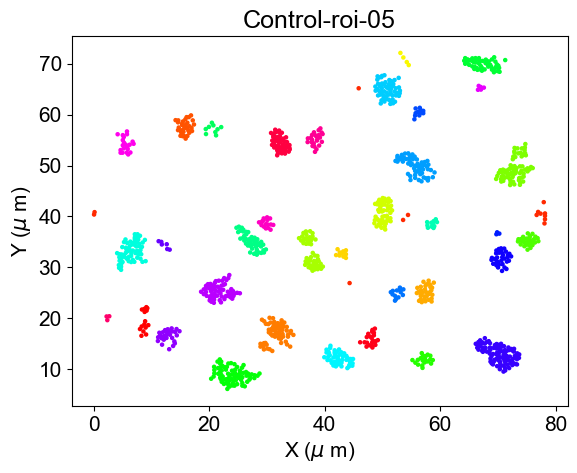

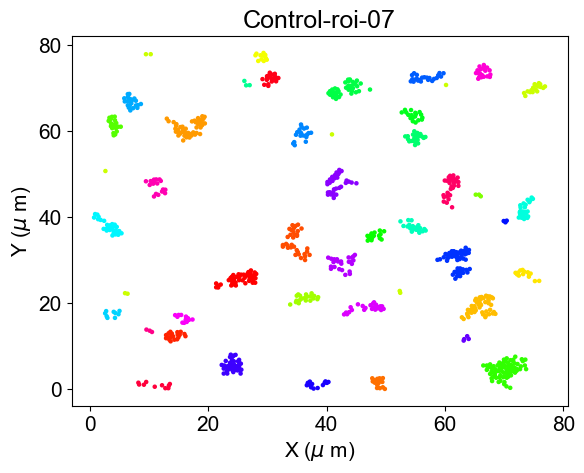

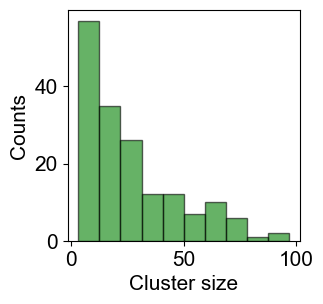

Total number of clusters:  168
Total number of clusters with at least  40  points is: 38


In [7]:
# Visualize clustering performance

cluster_sizes = []

for key in points_size_dict['points'].keys(): 
    
    clusters = points_size_dict['clusters'][key]
    points = points_size_dict['points'][key]
     
    counts_of_points_in_clusters = Counter(clusters)
    cluster_sizes += [counts for counts in counts_of_points_in_clusters.values()]

    # Coloring clusters randomly
    color_array = np.arange(np.max(clusters)+1)
    np.random.shuffle(color_array)
    color_assignments = [color_array[clust_num] for clust_num in clusters]

    # Visualize the clusters
    plt.scatter(points[:, 0], points[:, 1], s=5, c=color_assignments, cmap='hsv')
    plt.xlabel(r'X ($\mu$ m)')
    plt.ylabel(r'Y ($\mu$ m)')
    plt.title(key)
    plt.show()
    plt.close()
    
fig, axs = plt.subplots(1,1,figsize=(3,3))
axs.hist(cluster_sizes, edgecolor='k', color='g', alpha=0.6)
axs.set_xlabel('Cluster size')
axs.set_ylabel('Counts')
plt.show()
plt.close()

print('Total number of clusters: ', str(len(cluster_sizes)))

min_num_per_cluster = 40
print('Total number of clusters with at least ', str(min_num_per_cluster), ' points is:' ,str(len(np.where(np.array(cluster_sizes) > min_num_per_cluster)[0])))

In [8]:
def lsw_pdf(r, mean=1.0):
    """Function to compute the probability density according to the Lifschitz-Wagner-Slyozov distribution for coarsening"""
    pdf = np.zeros(len(r))
    for i in range(len(r)):
        # LSW CDF reaches the value of 1 at 1.5*mean and doesn't change after that. 
        if r[i] > 1.5*mean:
            pdf[i] = 0.0
        else:
            pdf[i] = (1.0/mean)*(4/9)*(r[i]/mean)**2 *(1 + r[i]/(3*mean))**(-7/3)*(1 - (2*r[i])/(3*mean))**(-11/3)*np.exp((2*r[i])/(3*mean)/((2*r[i])/(3*mean) - 1))
    return pdf

def lsw_cdf(r, mean=1.0, dr=0.01):
    """Calculate the cumulative distribution function from the lsw distribution for a particular value of r""" 
    cdf = np.zeros(len(r))
    r_range = np.arange(np.min(r), np.max(r), dr)
    pdf = lsw_pdf(r=r_range, mean=mean)
    for i in range(len(r)):
        cdf[i] = np.sum(pdf[r_range < r[i]])/np.sum(pdf)
    return cdf

CramerVonMisesResult(statistic=0.16652315917099972, pvalue=0.34294946582779706)


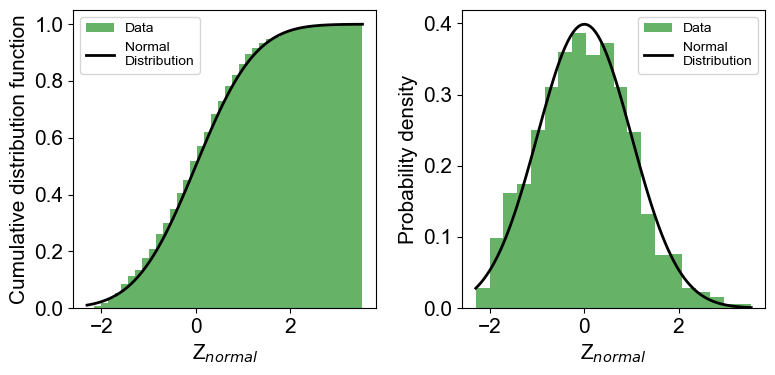

CramerVonMisesResult(statistic=1.9717145996951173, pvalue=1.4707345811437733e-05)


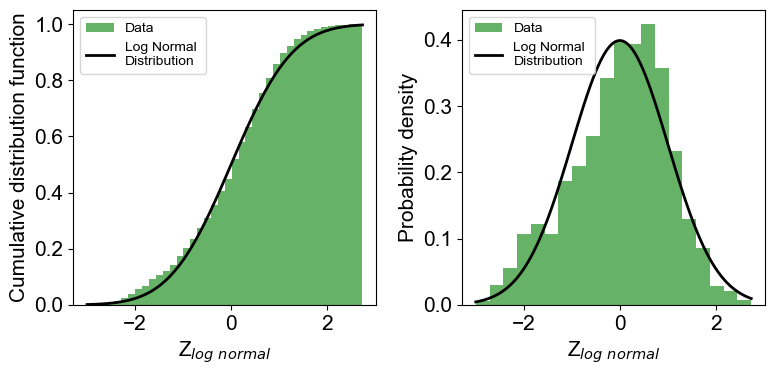

CramerVonMisesResult(statistic=10.227854240023602, pvalue=2.6603940161962214e-09)


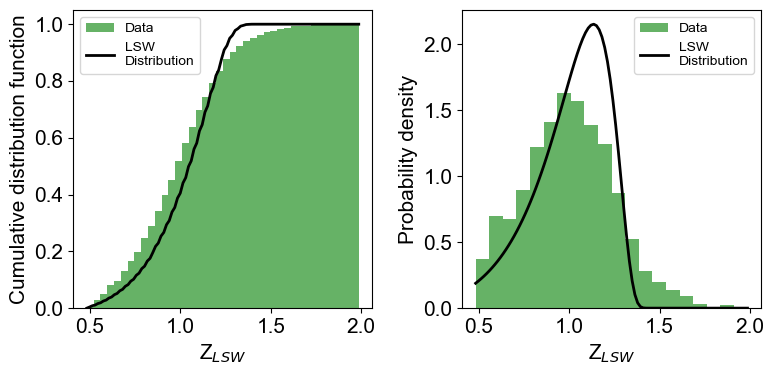

In [9]:
# Get the Z scores of the FC sizes in different clusters and compare the distribution shapes

z_values = np.array([], dtype=float)
log_z_values = np.array([], dtype=float)
lsw_norm_values = np.array([], dtype=float)

min_num_per_cluster = 40

for key in points_size_dict['points'].keys(): 
    
    points = points_size_dict['points'][key]
    radii = points_size_dict['size'][key]
    clusters = points_size_dict['clusters'][key]
    counts_of_points_in_clusters = Counter(clusters)
    
    for clust_num, counts in counts_of_points_in_clusters.items():
        if counts >= min_num_per_cluster and clust_num >=0:
            radii_in_cluster = radii[clusters == clust_num]    
            z_values = np.append(z_values, zscore(radii_in_cluster))
            lsw_norm_values = np.append(lsw_norm_values, radii_in_cluster/np.mean(radii_in_cluster))
            log_z_values = np.append(log_z_values, zscore(np.log(radii_in_cluster)))
            
# Cramer Von Mises test for normal distribution

result = cramervonmises(z_values, cdf='norm')
print(result)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].hist(z_values, bins=40, density=True, cumulative=True, alpha=0.6, color='g', label='Data')
axs[1].hist(z_values, bins=20, density=True, alpha=0.6, color='g', label='Data')

x = np.linspace(np.min(z_values), np.max(z_values), 100)
cum_d = norm.cdf(x, 0.0, 1.0)
prob_d = norm.pdf(x, 0.0, 1.0)
axs[0].plot(x, cum_d, 'k', linewidth=2, label='Normal \nDistribution')
axs[1].plot(x, prob_d, 'k', linewidth=2, label='Normal \nDistribution')

# plt.title('Normal Distribution')
# plt.xlabel(r'$z_{normal} = (x-\mu)/\sigma$')
axs[0].set_xlabel(r'Z$_{normal}$')
axs[0].set_ylabel('Cumulative distribution function')
axs[1].set_xlabel(r'Z$_{normal}$')
axs[1].set_ylabel('Probability density')

axs[0].legend(fontsize=10)
axs[1].legend(fontsize=10)
plt.tight_layout()
plt.savefig('Figures_for_paper/Control_fitting_distribution_with_cell_cell_variability_normal.pdf', format='pdf', dpi=600)
plt.savefig('Figures_for_paper/Control_fitting_distribution_with_cell_cell_variability_normal.svg', format='svg', dpi=600)
plt.show()
plt.close()

# Cramer Von Mises test for log normal distribution

result = cramervonmises(log_z_values, cdf='norm')
print(result)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].hist(log_z_values, bins=40, density=True, cumulative=True, alpha=0.6, color='g', label='Data')
axs[1].hist(log_z_values, bins=20, density=True, alpha=0.6, color='g', label='Data')

x = np.linspace(np.min(log_z_values), np.max(log_z_values), 100)
cum_d = norm.cdf(x, 0.0, 1.0)
prob_d = norm.pdf(x, 0.0, 1.0)
axs[0].plot(x, cum_d, 'k', linewidth=2, label='Log Normal \nDistribution')
axs[1].plot(x, prob_d, 'k', linewidth=2, label='Log Normal \nDistribution')

# plt.title('Normal Distribution')
# plt.xlabel(r'$z_{normal} = (x-\mu)/\sigma$')
axs[0].set_xlabel(r'Z$_{log~normal}$')
axs[0].set_ylabel('Cumulative distribution function')
axs[1].set_xlabel(r'Z$_{log~normal}$')
axs[1].set_ylabel('Probability density')

axs[0].legend(fontsize=10)
axs[1].legend(fontsize=10)

plt.tight_layout()
plt.savefig('Figures_for_paper/Control_fitting_distribution_with_cell_cell_variability_log_normal.pdf', format='pdf', dpi=600)
plt.savefig('Figures_for_paper/Control_fitting_distribution_with_cell_cell_variability_log_normal.svg', format='svg', dpi=600)
plt.show()
plt.close()

# Cramer Von Mises test for LSW distribution

result = cramervonmises(lsw_norm_values, cdf=lsw_cdf)
print(result)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].hist(lsw_norm_values, bins=40, density=True, cumulative=True, alpha=0.6, color='g', label='Data')
axs[1].hist(lsw_norm_values, bins=20, density=True, alpha=0.6, color='g', label='Data')

x = np.linspace(np.min(lsw_norm_values), np.max(lsw_norm_values), 100)
cum_d = lsw_cdf(x, 1.0)
prob_d = lsw_pdf(x, 1.0)
axs[0].plot(x, cum_d, 'k', linewidth=2, label='LSW \nDistribution')
axs[1].plot(x, prob_d, 'k', linewidth=2, label='LSW \nDistribution')

# plt.title('Normal Distribution')
# plt.xlabel(r'$z_{normal} = (x-\mu)/\sigma$')
axs[0].set_xlabel(r'Z$_{LSW}$')
axs[0].set_ylabel('Cumulative distribution function')
axs[1].set_xlabel(r'Z$_{LSW}$')
axs[1].set_ylabel('Probability density')

axs[0].legend(fontsize=10)
axs[1].legend(fontsize=10)

plt.tight_layout()
plt.savefig('Figures_for_paper/Control_fitting_distribution_with_cell_cell_variability_lsw.pdf', format='pdf', dpi=600)
plt.savefig('Figures_for_paper/Control_fitting_distribution_with_cell_cell_variability_lsw.svg', format='svg', dpi=600)
plt.show()
plt.close()